<a href="https://colab.research.google.com/github/Frank497/NTHU_2023_DLBOI_HW/blob/main/hw2/lab3_CE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">

# National Tsing Hua University

### Fall 2023

#### 11210IPT 553000

#### Deep Learning in Biomedical Optical Imaging

## Lab 3: Hyperparameter Tuning

</div>


In [ ]:
# # Download dataset
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy
!wget https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy


--2023-10-14 09:30:00--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/normal.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65536128 (62M) [application/octet-stream]
Saving to: ‘normal.npy’

normal.npy          100%[===================>]  62.50M   361MB/s    in 0.2s    

2023-10-14 09:30:05 (361 MB/s) - ‘normal.npy’ saved [65536128/65536128]

--2023-10-14 09:30:05--  https://raw.githubusercontent.com/TacoXDD/homeworks/master/dataset/train/pneumonia.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length

## A. Data Loading and Preprocessing

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import csv
import numpy as np

# Load Dataset
abnormal_scans = np.load('pneumonia.npy')
normal_scans = np.load('normal.npy')

print(f'Shape of abnormal_scans: {abnormal_scans.shape}')
print(f'Shape of normal_scans: {normal_scans.shape}')

# For the data having presence of pneumonia assign 1, for the normal ones assign 0.

abnormal_labels = np.ones((abnormal_scans.shape[0],))
normal_labels = np.zeros((normal_scans.shape[0],))

split_point = 800

x_train = np.concatenate((abnormal_scans[:split_point], normal_scans[:split_point]), axis=0)
y_train = np.concatenate((abnormal_labels[:split_point], normal_labels[:split_point]), axis=0)
x_val = np.concatenate((abnormal_scans[split_point:], normal_scans[split_point:]), axis=0)
y_val = np.concatenate((abnormal_labels[split_point:], normal_labels[split_point:]), axis=0)

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).long()
x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).long()

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f'Number of samples in train and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')
print(f'X_train: max value is {x_train.max().item()}, min value is {x_train.min().item()}, data type is {x_train.dtype}.')

Shape of abnormal_scans: (1000, 256, 256)
Shape of normal_scans: (1000, 256, 256)
Number of samples in train and validation are 1600 and 400.
X_train: max value is 255.0, min value is 0.0, data type is torch.float32.


## B. Defining Neural Networks in PyTorch

In [ ]:
import torch.nn as nn
'''
# Model in Lab 2
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(256*256*1, 256),
    nn.ReLU(),
    nn.Dropout(0.72),
    nn.Linear(256, 2)
).cuda()
'''
# for BCE/CE compare
model = nn.Sequential(
    nn.Flatten(),

    nn.Linear(256*256*1, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(64, 2),
    nn.Softmax()
).cuda()

print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=65536, out_features=64, bias=True)
  (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=64, out_features=64, bias=True)
  (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.5, inplace=False)
  (13): Linear(in_features=64, out_features=2, bias=True)
  (14): Softmax(dim=None)
)


## C. Training the Neural Network

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 90
best_val_loss = float('inf')

# Criterion and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
# lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.1)


with open('train outputs.csv', 'w') as f:
  # using csv.writer method from CSV package
  #write = csv.writer(f)

  for epoch in range(epochs):
      # Training
      model.train()
      total_loss = 0.0
      train_correct = 0
      total_train_samples = 0

      for images, labels in train_loader:
          images = images.cuda()
          images = images / 255.
          labels = labels.cuda()
          optimizer.zero_grad()
          outputs = model(images)
     # using csv.writer method from CSV package
#          write.writerow(outputs[:,0])
#          write.writerow(outputs[:,1])

          labels = labels.long()
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()

          train_predicted = outputs.argmax(-1)
          train_correct += (train_predicted.float() == labels).sum().item()
          total_train_samples += labels.size(0)
      #print(outputs[:,0])
      avg_train_loss = total_loss / len(train_loader)
      train_accuracy = 100. * train_correct / total_train_samples

      # Validation
      model.eval()
      total_val_loss = 0.0
      correct = 0
      total = 0
      with torch.no_grad():
          for images, labels in val_loader:
              images = images.cuda()
              images = images / 255.
              labels = labels.cuda()
              outputs = model(images)

              labels = labels.long()

              loss = criterion(outputs, labels)
              total_val_loss += loss.item()

              predicted = outputs.argmax(-1)
              correct += (predicted.float() == labels).sum().item()
              total += labels.size(0)

      avg_val_loss = total_val_loss / len(val_loader)
      val_accuracy = 100. * correct / total

      print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

      # Learning rate update
      lr_scheduler.step()

      # Checkpoint
      if avg_val_loss < best_val_loss:
          best_val_loss = avg_val_loss
          torch.save(model.state_dict(), 'model_classification.pth')

      # Store performance
      train_losses.append(avg_train_loss)
      train_accuracies.append(train_accuracy)
      val_losses.append(avg_val_loss)
      val_accuracies.append(val_accuracy)

tensor([0.6399, 0.0786, 0.3706, 0.9997, 0.3731, 0.3588, 0.5797, 0.4858, 0.4611,
        0.6002, 0.0229, 0.4300, 0.7972, 0.0367, 0.6334, 0.1270, 0.8301, 0.5390,
        0.2964, 0.1022, 0.9707, 0.0445, 0.8069, 0.1482, 0.4435, 0.6440, 0.0504,
        0.9333, 0.0522, 0.7838, 0.4232, 0.7202], device='cuda:0',
       grad_fn=<SelectBackward0>)
Epoch 1/90, Train Loss: 0.5945, Train Accuracy: 72.19%, Val Loss: 0.4816, Val Accuracy: 90.00%
tensor([0.0037, 0.9877, 0.9174, 0.4550, 0.0116, 0.0584, 0.0263, 0.7896, 0.9847,
        0.0229, 0.7598, 0.9385, 0.2528, 0.0042, 0.8855, 0.0641, 0.9937, 0.4988,
        0.8984, 0.9909, 0.9270, 0.1895, 0.1850, 0.0286, 0.1265, 0.0124, 0.7317,
        0.9170, 0.8884, 0.0197, 0.0865, 0.9313], device='cuda:0',
       grad_fn=<SelectBackward0>)
Epoch 2/90, Train Loss: 0.4839, Train Accuracy: 86.19%, Val Loss: 0.4343, Val Accuracy: 90.00%
tensor([7.1292e-01, 1.2453e-03, 1.3046e-01, 9.9978e-01, 8.0875e-03, 9.9848e-01,
        9.1458e-01, 5.8878e-01, 8.9784e-02, 9.9757

### Visualizing model performance

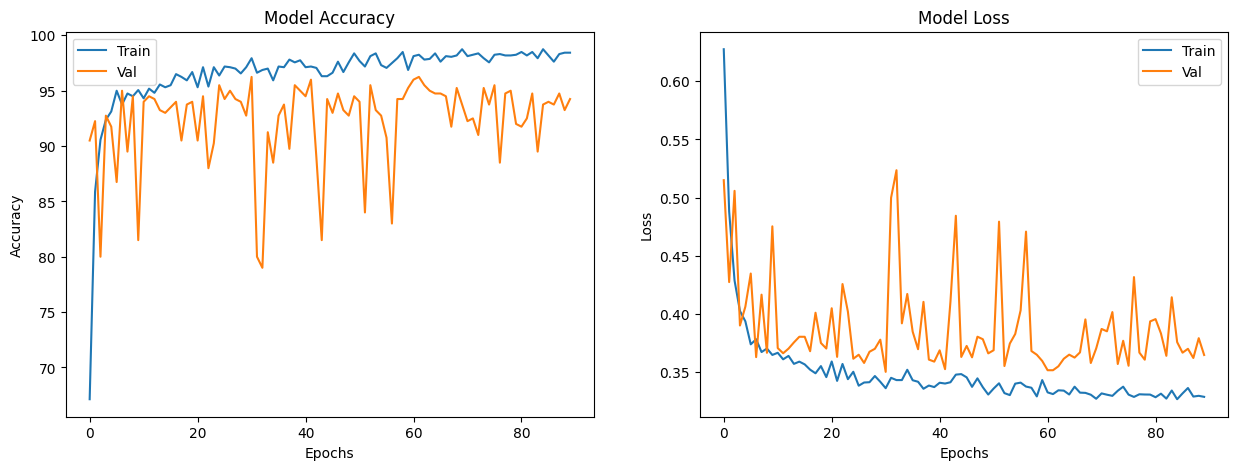

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

In [ ]:
import csv
with open('CE neuron model.csv', 'w') as f:

    # using csv.writer method from CSV package
    write = csv.writer(f)
    write.writerow(['train accuracies'])
    write.writerow(train_accuracies)
    write.writerow(['validation accuracy'])
    write.writerow(val_accuracies)
    write.writerow(['train loss'])
    write.writerow(train_losses)
    write.writerow(['validation loss'])
    write.writerow(val_losses)
    write.writerow(outputs[:,1])